/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_39066/1986339574.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = demand_data.groupby(['City Name', 'Delivery Mode', 'Leakage Level']).agg(
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_39066/1986339574.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = demand_data.groupby(['City Name', 'Delivery Mode', 'Leakage Level']).agg(
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_39066/1986339574.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a futur

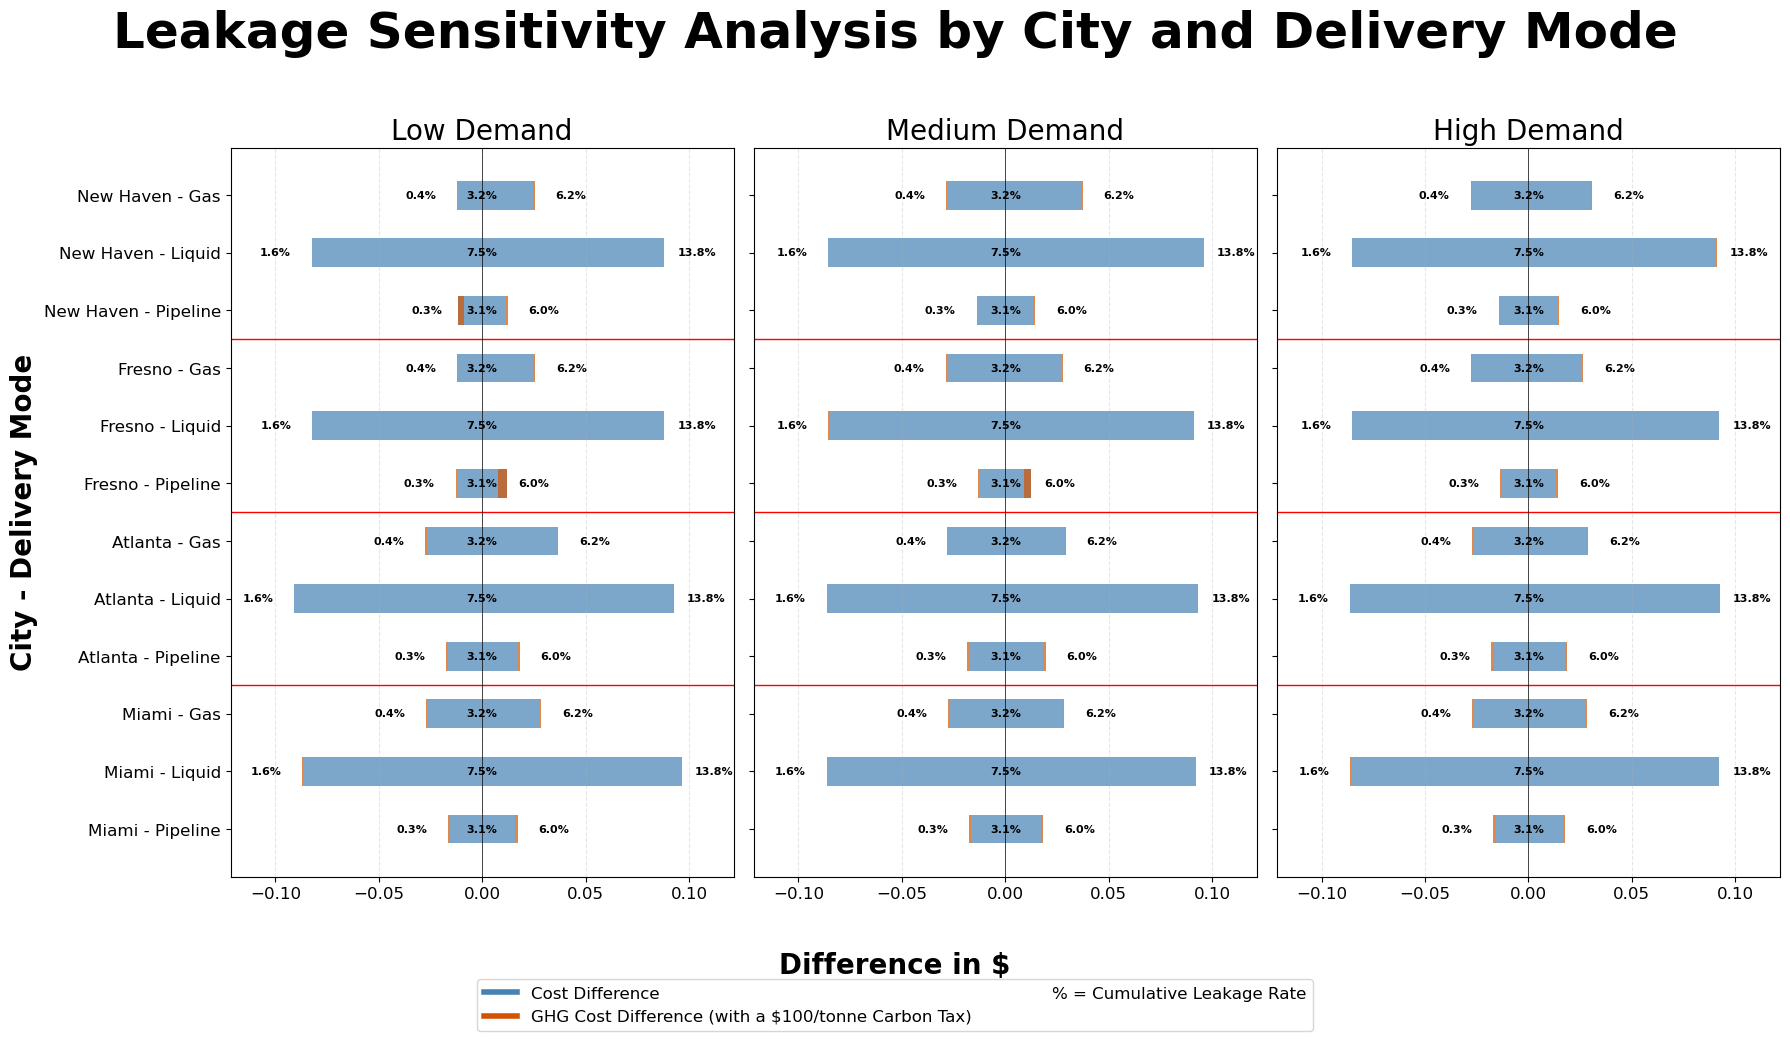

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load the data
file_path = 'Distribution Paper - Leakage Sensitivity (New).csv'
data = pd.read_csv(file_path)

# Convert relevant columns to numeric, handling any non-numeric issues
data['GHG Cost Difference'] = pd.to_numeric(data['GHG Cost Difference'], errors='coerce')
data['Cost Differnce'] = pd.to_numeric(data['Cost Differnce'], errors='coerce')
data['Cumulative Leakage Rate'] = pd.to_numeric(data['Cumulative Leakage Rate'], errors='coerce')

# Custom city and delivery mode order
city_order = ['Miami', 'Atlanta', 'Fresno', 'New Haven']
delivery_order = ['Pipeline', 'Liquid', 'Gas']
data['City Name'] = pd.Categorical(data['City Name'], categories=city_order, ordered=True)
data['Delivery Mode'] = pd.Categorical(data['Delivery Mode'], categories=delivery_order, ordered=True)

# Sort the data by the custom order
data = data.sort_values(by=['City Name', 'Delivery Mode'])

# Determine the maximum absolute value for symmetric x-axis limits
max_abs_value = data[['GHG Cost Difference', 'Cost Differnce']].abs().sum(axis=1).max()

# Define function to create the tornado plot with annotations for the cumulative leakage rate
def create_corrected_stacked_tornado_plot(data, demand_level, ax):
    # Filter data by demand level
    demand_data = data[data['Demand Level'] == demand_level]
    
    # Group data by 'City Name' and 'Delivery Mode' to calculate values for each leakage level
    grouped_data = demand_data.groupby(['City Name', 'Delivery Mode', 'Leakage Level']).agg(
        GHG_Cost=('GHG Cost Difference', 'mean'),
        Cost_Diff=('Cost Differnce', 'mean'),
        Cum_Leakage_Rate=('Cumulative Leakage Rate', 'mean')
    ).reset_index()

    # Generate bars for each city and delivery mode combination
    y_labels = []
    city_boundaries = []  # To track positions where city dividers should be added
    last_city = None

    for i, (city, delivery) in enumerate(grouped_data[['City Name', 'Delivery Mode']].drop_duplicates().values):
        # Check if we need to add a red line before the current city
        if last_city is not None and city != last_city:
            city_boundaries.append(i - 0.5)
        
        last_city = city

        # Filter data for the specific city and delivery mode
        city_mode_data = grouped_data[(grouped_data['City Name'] == city) & (grouped_data['Delivery Mode'] == delivery)]
        
        # Extract values for low, medium, and high leakage levels
        for leakage_level in ['Low', 'Medium', 'High']:
            values = city_mode_data[city_mode_data['Leakage Level'] == leakage_level][['Cost_Diff', 'GHG_Cost', 'Cum_Leakage_Rate']].values
            if len(values) > 0:
                cost_diff, ghg_cost, cum_leakage_rate = values.flatten()
                bar_position = i

                # Plot the Cost Difference bar in blue with opacity
                ax.barh(bar_position, cost_diff, color='#4682B4', alpha=0.7, height=0.5)  # Blue for Cost Difference
                
                # Plot the GHG Cost Difference bar in orange with opacity, shifted to the right of the cost difference
                ax.barh(bar_position, ghg_cost, color='#D35400', alpha=0.7, left=cost_diff, height=0.5)  # Orange for GHG Cost Difference

                # Determine the text alignment for the annotations based on the leakage level
                ha_position = 'left' if leakage_level == 'Low' else 'center' if leakage_level == 'Medium' else 'right'
                x_offset = -0.025 if leakage_level == 'Low' else 0 if leakage_level == 'Medium' else 0.025

                # Add the text annotation with consistent color (black) and bold formatting
                ax.text(cost_diff + ghg_cost + x_offset, bar_position, f"{cum_leakage_rate * 100:.1f}%",
                        va='center', ha=ha_position, fontsize=8, color='black', fontweight=580)

        # Add label for each city-delivery combination
        y_labels.append(f"{city} - {delivery}")

    # Add specific red lines between the specified cities
    for boundary in city_boundaries:
        ax.axhline(boundary, color='red', linewidth=1)

    # Formatting
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.axvline(0, color='black', linewidth=0.5)  # Center line at zero
    ax.set_xlim(-max_abs_value-0.025, max_abs_value+0.025)  # Symmetric x-axis range
    ax.set_title(f"{demand_level} Demand", fontsize=20)
    ax.grid(axis='x', linestyle='--', alpha=0.3)  # Light grid lines for a cleaner look
    if demand_level == 'Low':
        ax.set_ylabel("City - Delivery Mode", fontsize=20, fontweight = 'bold')

# Create a figure with three subplots, one for each demand level
fig, axs = plt.subplots(1, 3, figsize=(18, 10), sharey=True)

# Generate corrected stacked tornado plots for each demand level
for ax, demand_level in zip(axs, ['Low', 'Medium', 'High']):
    create_corrected_stacked_tornado_plot(data, demand_level, ax)

# Manually add a single legend at the figure level with specified labels
legend_elements = [
    Line2D([0], [0], color='#4682B4', lw=4, label='Cost Difference'),
    Line2D([0], [0], color='#D35400', lw=4, label='GHG Cost Difference (with a $100/tonne Carbon Tax)'),
    Line2D([0], [0], color='none', label='% = Cumulative Leakage Rate')  # Custom text entry for the legend
]

fig.legend(handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)
# Set common x-axis label and layout adjustments
fig.supxlabel("Difference in $", fontsize=20, fontweight = 'bold')
fig.suptitle("Leakage Sensitivity Analysis by City and Delivery Mode", fontsize=36, fontweight = 'bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Leakage_Sensitivity_BarPlot_New_9_24.png', bbox_inches='tight')
plt.show()

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_39066/1690325643.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = demand_data.groupby(['City Name', 'Delivery Mode', 'Leakage Level']).agg(


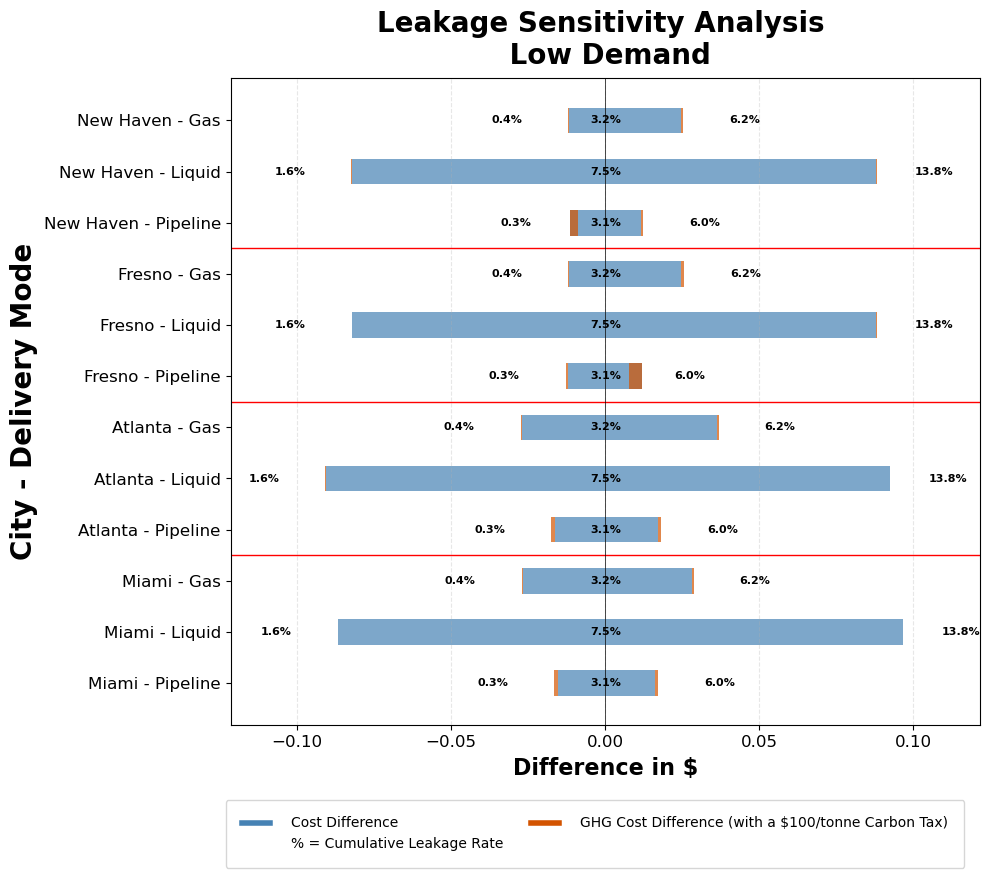

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_39066/1690325643.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = demand_data.groupby(['City Name', 'Delivery Mode', 'Leakage Level']).agg(


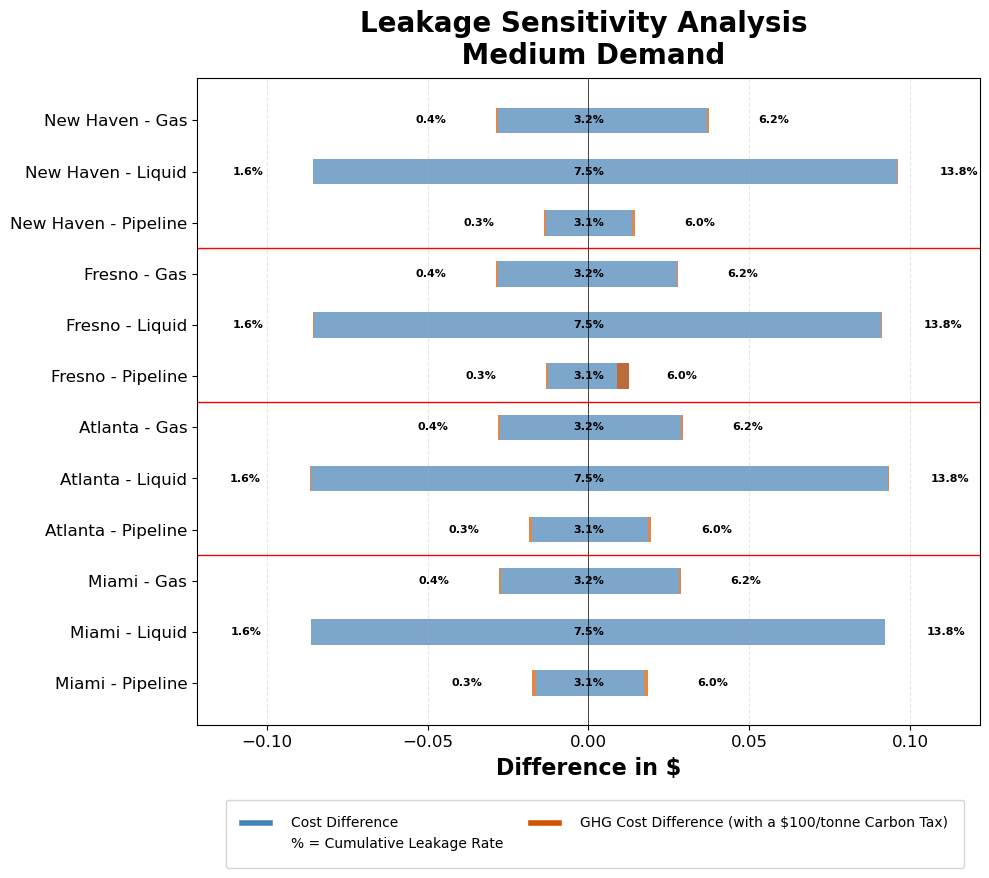

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_39066/1690325643.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = demand_data.groupby(['City Name', 'Delivery Mode', 'Leakage Level']).agg(


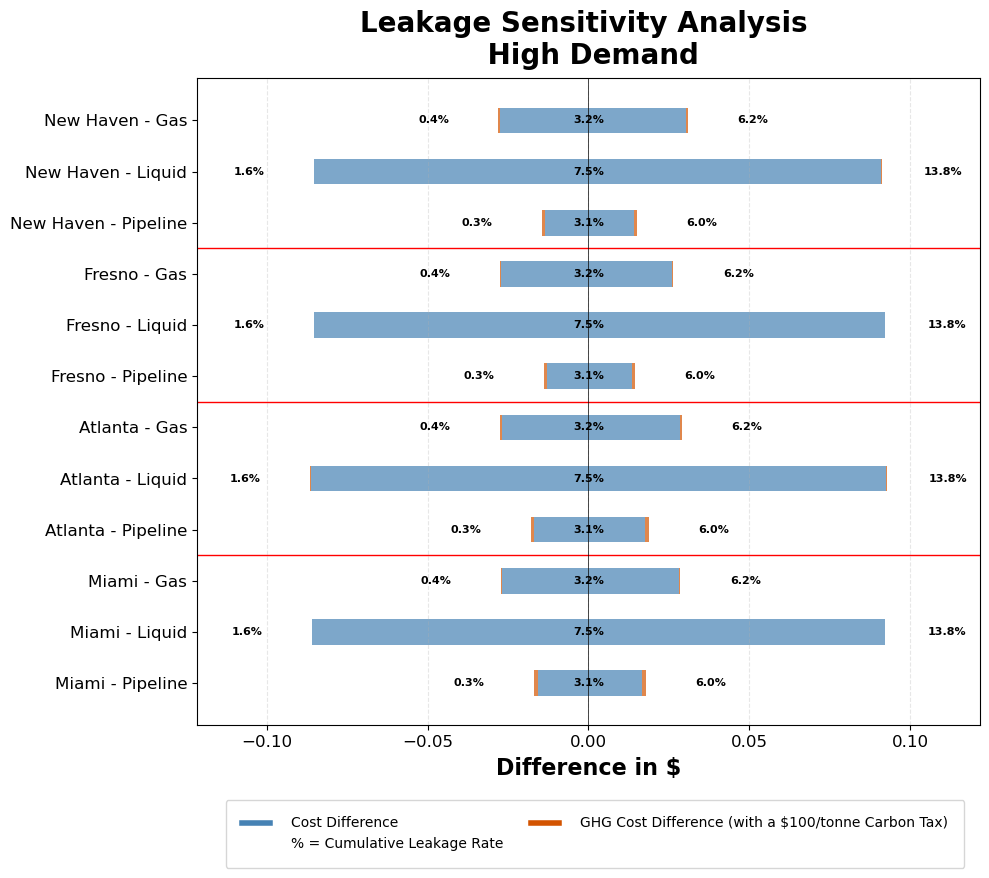

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load and preprocess the data (remains the same)
file_path = 'Distribution Paper - Leakage Sensitivity (New).csv'
data = pd.read_csv(file_path)

data['GHG Cost Difference'] = pd.to_numeric(data['GHG Cost Difference'], errors='coerce')
data['Cost Differnce'] = pd.to_numeric(data['Cost Differnce'], errors='coerce')
data['Cumulative Leakage Rate'] = pd.to_numeric(data['Cumulative Leakage Rate'], errors='coerce')

city_order = ['Miami', 'Atlanta', 'Fresno', 'New Haven']
delivery_order = ['Pipeline', 'Liquid', 'Gas']
data['City Name'] = pd.Categorical(data['City Name'], categories=city_order, ordered=True)
data['Delivery Mode'] = pd.Categorical(data['Delivery Mode'], categories=delivery_order, ordered=True)
data = data.sort_values(by=['City Name', 'Delivery Mode'])

max_abs_value = data[['GHG Cost Difference', 'Cost Differnce']].abs().sum(axis=1).max()

# The tornado plot function remains unchanged
def create_corrected_stacked_tornado_plot(data, demand_level, ax):
    demand_data = data[data['Demand Level'] == demand_level]
    grouped_data = demand_data.groupby(['City Name', 'Delivery Mode', 'Leakage Level']).agg(
        GHG_Cost=('GHG Cost Difference', 'mean'),
        Cost_Diff=('Cost Differnce', 'mean'),
        Cum_Leakage_Rate=('Cumulative Leakage Rate', 'mean')
    ).reset_index()

    y_labels = []
    city_boundaries = []
    last_city = None

    for i, (city, delivery) in enumerate(grouped_data[['City Name', 'Delivery Mode']].drop_duplicates().values):
        if last_city is not None and city != last_city:
            city_boundaries.append(i - 0.5)
        last_city = city

        city_mode_data = grouped_data[(grouped_data['City Name'] == city) & (grouped_data['Delivery Mode'] == delivery)]
        for leakage_level in ['Low', 'Medium', 'High']:
            values = city_mode_data[city_mode_data['Leakage Level'] == leakage_level][['Cost_Diff', 'GHG_Cost', 'Cum_Leakage_Rate']].values
            if len(values) > 0:
                cost_diff, ghg_cost, cum_leakage_rate = values.flatten()
                bar_position = i
                ax.barh(bar_position, cost_diff, color='#4682B4', alpha=0.7, height=0.5)
                ax.barh(bar_position, ghg_cost, color='#D35400', alpha=0.7, left=cost_diff, height=0.5)
                ha_position = 'left' if leakage_level == 'Low' else 'center' if leakage_level == 'Medium' else 'right'
                x_offset = -0.025 if leakage_level == 'Low' else 0 if leakage_level == 'Medium' else 0.025
                ax.text(cost_diff + ghg_cost + x_offset, bar_position, f"{cum_leakage_rate * 100:.1f}%",
                        va='center', ha=ha_position, fontsize=8, color='black', fontweight=580)
        y_labels.append(f"{city} - {delivery}")

    for boundary in city_boundaries:
        ax.axhline(boundary, color='red', linewidth=1)

    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlim(-max_abs_value - 0.025, max_abs_value + 0.025)
    ax.set_title(f"{demand_level} Demand", fontsize=20)
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    if demand_level == 'Low':
        ax.set_ylabel("City - Delivery Mode", fontsize=20, fontweight='bold')

# Create separate plots for each demand level
for demand_level in ['Low', 'Medium', 'High']:
    fig, ax = plt.subplots(figsize=(10, 8))  # Create a new figure for each demand level
    create_corrected_stacked_tornado_plot(data, demand_level, ax)

    # Legend for each plot
    legend_elements = [
        Line2D([0], [0], color='#4682B4', lw=4, label='Cost Difference'),
        Line2D([0], [0], color='none', label='% = Cumulative Leakage Rate'),
        Line2D([0], [0], color='#D35400', lw=4, label='GHG Cost Difference (with a $100/tonne Carbon Tax)')
        
    ]
    fig.legend(
        handles=legend_elements, 
        loc='lower center', 
        bbox_to_anchor=(0.6, -0.1),  # Center below the x-axis
        ncol=2, 
        fontsize=10,  # Slightly larger font for readability
        frameon=True,  # Enable legend border
        fancybox=True,  # Rounded corners for the legend box
        shadow=False,  # Optional: adds a shadow effect
        handletextpad=1.5,  # Increase space between legend handles and text
        columnspacing=2.0,  # Increase space between columns
        borderpad=1.2  # Padding inside the legend box
    )

    # Set x-axis label and save the plot
    #fig.supxlabel("Difference in $", fontsize=16, fontweight='bold')
    #fig.suptitle(f"Leakage Sensitivity Analysis - {demand_level} Demand", fontsize=18, fontweight='bold')
    # Set title and x-axis label closer to the plot
    ax.set_title(
        f"Leakage Sensitivity Analysis \n {demand_level} Demand", 
        fontsize=20, fontweight='bold', pad=10, loc='center'
    )

    ax.set_xlabel('Difference in $', 
              fontsize=16, fontweight='bold', labelpad=5)  # Reduce padding to bring it closer to the plot
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(f'Final Plots/Leakage_Sensitivity_{demand_level}_Demand (New).png', bbox_inches='tight')
    plt.show()
